In [406]:
import numpy as np
import scipy.optimize

In [407]:
import matplotlib.pyplot as plt
from matplotlib import rc

plt.rcParams["figure.figsize"] = [6, 6]
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1 - d2) / 2, ylim[1] + (d1 - d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1 - d2) / 2, xlim[1] - (d1 - d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1 - d2) / 2, ylim[1] + (d1 - d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1 - d2) / 2, xlim[1] - (d1 - d2) / 2))

In [506]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_trajectory(trajectories, labels=None):
    fig, ax = plt.subplots()
    
    if type(trajectories[0]) != list:
        trajectories = [trajectories]
    
    n = len(trajectories[0])

    def step(t):
        ax.cla()
        #ax.plot([min_point[0]], [min_point[1]], 'o', color='green')
        # Level contours
        delta = 0.3
        x = np.arange(-5, 15, delta)
        y = np.arange(-5, 15, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        # print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = func([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [-15, -10, 0], colors=["blue", "purple", "red"])

        for i in range(len(trajectories)):
            if labels != None:
                ax.plot([u[0] for u in trajectories[i][:t]], [u[1] for u in trajectories[i][:t]], label=labels[i])
            else:
                ax.plot([u[0] for u in trajectories[i][:t]], [u[1] for u in trajectories[i][:t]])
            ax.plot([u[0] for u in trajectories[i][:t]], [u[1] for u in trajectories[i][:t]], 'o')
        
        if labels != None:
            plt.legend()
        fix_scaling(ax)
        ax.axis('off')

    return FuncAnimation(fig, step, frames=range(n), interval=600)

In [507]:
A = np.array([
    [1.0, -0.6],
    [0.6, 0.8]
])
b = np.array([-5.0, -6.0])
c = 0.3

cA = np.array([[1.0, 1.0], [-1.0, 0.0], [0.0, -1.0]])
cb = np.array([10.0, 0.0, 0.0])

def func(x):
    x = np.array(x)
    return np.dot(x.T ,np.dot(A, x)) + np.dot(b.T, x) + c

def f_grad(x):
    x = np.array(x)
    return np.dot(x, A + A.T) + b

def func_gessian(A):
    return A + A.T

In [508]:
def get_inner_point():
    b_ub = np.array([b - 0.0001 for b in cb])
    return scipy.optimize.linprog(c=np.zeros(len(cA.T)), A_ub=cA, b_ub=b_ub)

In [509]:
def g(x, a, b):
    x = np.array(x)
    a = np.array(a)
    return np.dot(x, a.T) - b

def g_gradient(a, b):
    return a

In [510]:
start_point = np.array([1, 1])

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


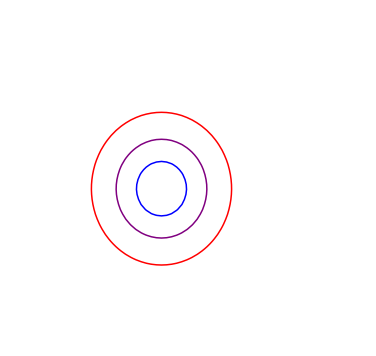

In [511]:
def inner_point(start_point):
    t = 1.0
    alpha = 2
    f_gessian = func_gessian(A)
    
    def get_grad(x):
        res = np.zeros(len(x))
        for i in range(len(cA)):
            res -= 1 / g(x, cA[i], cb[i]) * g_gradient(cA[i], cb[i])
        return res    
    
    def get_gess(x):
        res = np.zeros((len(x), len(x)))
        for i in range(len(cA)):
            res += 1 / g(x, cA[i], cb[i]) ** 2 * np.dot(g_gradient(cA[i], cb[i]).T, g_gradient(cA[i], cb[i]))
        return res
    
    traj = []
    cur_x = start_point.copy()
    traj.append(cur_x.copy())
    for i in range(10):
        grad = t * func_gradient(cur_x) + get_grad(cur_x)
        gess = t * f_gessian + get_gess(cur_x)
        cur_x = cur_x - np.dot(np.linalg.inv(gess), grad.T)
        t *= alpha
        traj.append(cur_x.copy())
        
    return traj

traj = inner_point(start_point)
base_animation = animate_trajectory(traj)
HTML(base_animation.to_html5_video())